# RAVDESS Emotion Recognition: Hyperparameter Tuning

This notebook focuses on hyperparameter tuning for the best-performing models from the preliminary analysis.

**Models tuned:**
- Random Forest
- Gradient Boosting Classifier

**Tuning approaches:**
1. RandomizedSearchCV
2. Optuna (Bayesian Optimization)

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score
from itertools import cycle

import optuna # type: ignore
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Load Dataset

In [4]:
dataset = pd.read_csv("../data/ABT_1_ravdess.csv")

In [5]:
display(dataset.head())
dataset.shape

,modality,vocal_channel,intensity,statement,repetition,actor,emotion,gender,loudness_db,y_0,...,y_89986,y_89987,y_89988,y_89989,y_89990,y_89991,y_89992,y_89993,y_89994,y_89995
0,3,1,1,2,1,16,angry,Female,-64.729790,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,1,1,2,2,16,fearful,Female,-65.943780,2.051093e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,2,1,2,16,fearful,Female,-51.392780,-8.404510e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2,1,1,16,angry,Female,-59.114307,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1,1,1,1,16,disgust,Female,-69.102135,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(1440, 90005)

## Preprocessing

In [6]:
# Prepare target variable
y = dataset["emotion"].copy()

# Prepare features
X = dataset.copy().drop(columns=["emotion"])

# Encode gender column: Male = 1, Female = 0
X['gender'] = X['gender'].map({'Male': 1, 'Female': 0})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")

Training set size: 1008
Test set size: 432
Number of features: 90004


## Baseline Models (for comparison)

Training baseline models to compare with tuned versions.

In [8]:
# Baseline Random Forest
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
rf_pipeline.fit(X_train, y_train)

train_score_rf = rf_pipeline.score(X_train, y_train)
test_score_rf = rf_pipeline.score(X_test, y_test)

print(f"Random Forest Baseline - Training Accuracy: {train_score_rf:.4f}")
print(f"Random Forest Baseline - Testing Accuracy: {test_score_rf:.4f}")

Random Forest Baseline - Training Accuracy: 1.0000
Random Forest Baseline - Testing Accuracy: 0.3287


In [9]:
# Baseline Gradient Boosting Classifier
gb_pipeline = make_pipeline(
    StandardScaler(), 
    GradientBoostingClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        subsample=1,
        max_features='sqrt',
        random_state=42
    )
)

gb_pipeline.fit(X_train, y_train)

train_score_gb = gb_pipeline.score(X_train, y_train)
test_score_gb = gb_pipeline.score(X_test, y_test)

print(f"GBC Baseline - Training Accuracy: {train_score_gb:.4f}")
print(f"GBC Baseline - Testing Accuracy: {test_score_gb:.4f}")

GBC Baseline - Training Accuracy: 0.9960
GBC Baseline - Testing Accuracy: 0.3519


# Hyperparameter Tuning with RandomizedSearchCV

Using RandomizedSearchCV to find optimal hyperparameters.

**Strategy:**
- `n_iter=8` (samples 8 random combinations)
- 5-fold cross-validation (`cv=5`)
- `n_jobs=-1` to use all CPU cores

## Random Forest Hyperparameter Tuning

In [10]:
# Define Random Forest hyperparameter grid
rf_param_grid = {
    'randomforestclassifier__n_estimators': [50, 100],
    'randomforestclassifier__max_depth': [5, 10, None],
    'randomforestclassifier__min_samples_split': [2, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

# Create Random Forest pipeline
rf_tuning_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))

# RandomizedSearchCV
print("Starting Random Forest hyperparameter tuning...")
rf_random_search = RandomizedSearchCV(
    rf_tuning_pipeline,
    param_distributions=rf_param_grid,
    n_iter=8,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

rf_random_search.fit(X_train, y_train)

print(f"\nBest parameters: {rf_random_search.best_params_}")
print(f"Best cross-validation score: {rf_random_search.best_score_:.4f}")

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': None}
Best cross-validation score: 0.3284


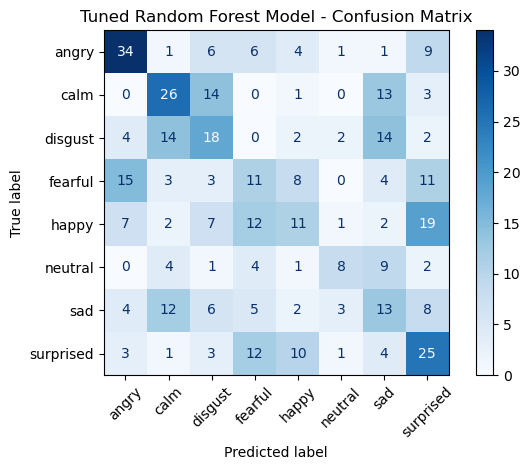

Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

       angry       0.51      0.55      0.53        62
        calm       0.41      0.46      0.43        57
     disgust       0.31      0.32      0.32        56
     fearful       0.22      0.20      0.21        55
       happy       0.28      0.18      0.22        61
     neutral       0.50      0.28      0.36        29
         sad       0.22      0.25      0.23        53
   surprised       0.32      0.42      0.36        59

    accuracy                           0.34       432
   macro avg       0.35      0.33      0.33       432
weighted avg       0.34      0.34      0.33       432

Training Accuracy: 1.0000
Testing Accuracy: 0.3380


In [11]:
# Evaluate best Random Forest model on test set
y_pred_rf_tuned = rf_random_search.best_estimator_.predict(X_test)

# Confusion Matrix
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
disp_rf_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned, 
                                        display_labels=rf_random_search.best_estimator_.classes_)
disp_rf_tuned.plot(cmap='Blues', xticks_rotation=45)
plt.title('Tuned Random Forest Model - Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report (Tuned Random Forest):")
print(classification_report(y_test, y_pred_rf_tuned))

# Calculate accuracy
train_score_rf_tuned = rf_random_search.best_estimator_.score(X_train, y_train)
test_score_rf_tuned = rf_random_search.best_estimator_.score(X_test, y_test)

print(f"Training Accuracy: {train_score_rf_tuned:.4f}")
print(f"Testing Accuracy: {test_score_rf_tuned:.4f}")

## Gradient Boosting Classifier Hyperparameter Tuning

In [12]:
# Define GBC hyperparameter grid
gbc_param_grid = {
    'gradientboostingclassifier__n_estimators': [50, 100],
    'gradientboostingclassifier__learning_rate': [0.1, 0.2],
    'gradientboostingclassifier__max_depth': [3, 5],
    'gradientboostingclassifier__subsample': [0.8, 1.0],
    'gradientboostingclassifier__max_features': ['sqrt', 'log2']
}

# Create GBC pipeline
gbc_tuning_pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42))

# RandomizedSearchCV
print("Starting Gradient Boosting Classifier hyperparameter tuning...")
gbc_random_search = RandomizedSearchCV(
    gbc_tuning_pipeline,
    param_distributions=gbc_param_grid,
    n_iter=8,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

gbc_random_search.fit(X_train, y_train)

print(f"\nBest parameters: {gbc_random_search.best_params_}")
print(f"Best cross-validation score: {gbc_random_search.best_score_:.4f}")

Starting Gradient Boosting Classifier hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters: {'gradientboostingclassifier__subsample': 1.0, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__max_features': 'log2', 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__learning_rate': 0.1}
Best cross-validation score: 0.3323


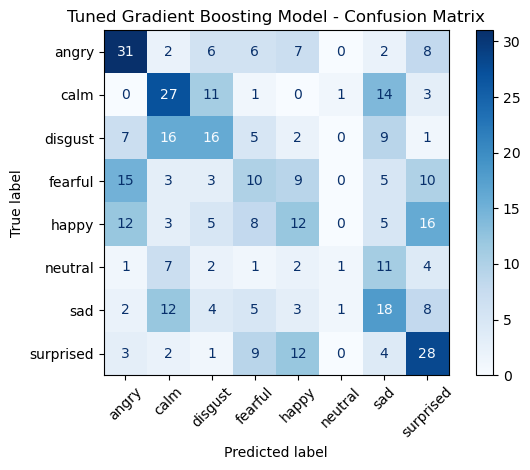

Classification Report (Tuned GBC):
              precision    recall  f1-score   support

       angry       0.44      0.50      0.47        62
        calm       0.38      0.47      0.42        57
     disgust       0.33      0.29      0.31        56
     fearful       0.22      0.18      0.20        55
       happy       0.26      0.20      0.22        61
     neutral       0.33      0.03      0.06        29
         sad       0.26      0.34      0.30        53
   surprised       0.36      0.47      0.41        59

    accuracy                           0.33       432
   macro avg       0.32      0.31      0.30       432
weighted avg       0.32      0.33      0.32       432

Training Accuracy: 1.0000
Testing Accuracy: 0.3310


In [13]:
# Evaluate best GBC model on test set
y_pred_gbc_tuned = gbc_random_search.best_estimator_.predict(X_test)

# Confusion Matrix
cm_gbc_tuned = confusion_matrix(y_test, y_pred_gbc_tuned)
disp_gbc_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_gbc_tuned, 
                                         display_labels=gbc_random_search.best_estimator_.classes_)
disp_gbc_tuned.plot(cmap='Blues', xticks_rotation=45)
plt.title('Tuned Gradient Boosting Model - Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report (Tuned GBC):")
print(classification_report(y_test, y_pred_gbc_tuned))

# Calculate accuracy
train_score_gbc_tuned = gbc_random_search.best_estimator_.score(X_train, y_train)
test_score_gbc_tuned = gbc_random_search.best_estimator_.score(X_test, y_test)

print(f"Training Accuracy: {train_score_gbc_tuned:.4f}")
print(f"Testing Accuracy: {test_score_gbc_tuned:.4f}")

## Model Comparison: Baseline vs RandomizedSearchCV

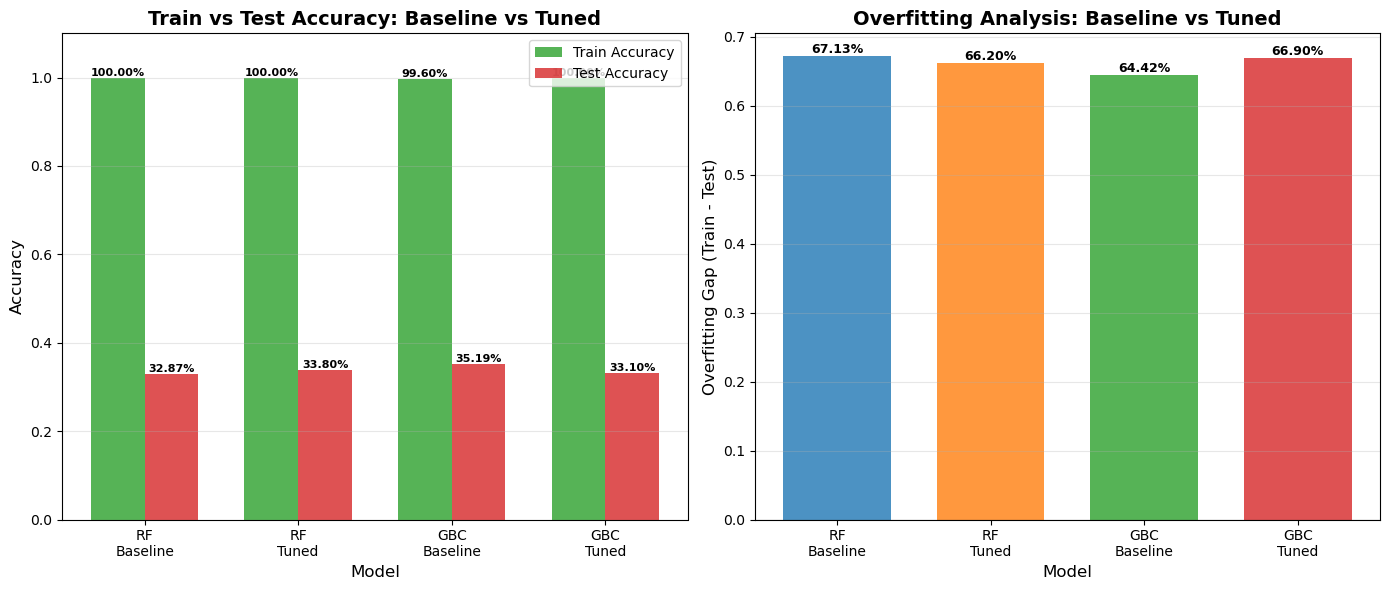

In [51]:
# Create comparison dataframe
comparison_data_basic = {
    'Model': [
        'Random Forest (Baseline)',
        'Random Forest (Tuned)',
        'GBC (Baseline)',
        'GBC (Tuned)'
    ],
    'Train Accuracy': [
        train_score_rf,
        train_score_rf_tuned,
        train_score_gb,
        train_score_gbc_tuned
    ],
    'Test Accuracy': [
        test_score_rf,
        test_score_rf_tuned,
        test_score_gb,
        test_score_gbc_tuned
    ]
}

comparison_df_basic = pd.DataFrame(comparison_data_basic)
comparison_df_basic['Accuracy Improvement'] = comparison_df_basic.groupby(comparison_df_basic.index // 2)['Test Accuracy'].diff()
comparison_df_basic['Overfitting Gap'] = comparison_df_basic['Train Accuracy'] - comparison_df_basic['Test Accuracy']

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Train vs Test Accuracy
models = ['RF\nBaseline', 'RF\nTuned', 'GBC\nBaseline', 'GBC\nTuned']
train_scores = comparison_df_basic['Train Accuracy']
test_scores = comparison_df_basic['Test Accuracy']

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_scores, width, alpha=0.8, label='Train Accuracy', color='#2ca02c')
bars2 = axes[0].bar(x + width/2, test_scores, width, alpha=0.8, label='Test Accuracy', color='#d62728')

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Train vs Test Accuracy: Baseline vs Tuned', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend(loc='upper right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# Plot 2: Overfitting Analysis
overfitting_gaps = comparison_df_basic['Overfitting Gap']

bars3 = axes[1].bar(x, overfitting_gaps, width*2, alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Overfitting Gap (Train - Test)', fontsize=12)
axes[1].set_title('Overfitting Analysis: Baseline vs Tuned', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, gap in zip(bars3, overfitting_gaps):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{gap:.2%}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add horizontal line at y=0
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

plt.tight_layout()

# Save plot
import os
os.makedirs('../output/EDA_plots', exist_ok=True)
plt.savefig('../output/EDA_plots/hyperparameter_tuning_baseline_vs_randomsearch.png', dpi=300, bbox_inches='tight')

plt.show()

# Hyperparameter Tuning with Optuna

Optuna uses Bayesian optimization (TPE sampler) for more intelligent hyperparameter search.

**Advantages over RandomizedSearchCV:**
- Learns from previous trials to suggest better parameters
- Can prune unpromising trials early (saves time)
- More efficient exploration of the search space
- Built-in visualization tools

## Random Forest with Optuna

In [15]:
# Define objective function for Random Forest
def objective_rf(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    
    # Create pipeline
    rf_pipeline_optuna = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(**params)
    )
    
    # Use cross-validation to evaluate
    scores = cross_val_score(rf_pipeline_optuna, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()

# Create study and optimize
print("Starting Random Forest optimization with Optuna...")
study_rf = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print(f"\nBest trial:")
print(f"  Value (CV Accuracy): {study_rf.best_trial.value:.4f}")
print(f"  Params: {study_rf.best_trial.params}")

Starting Random Forest optimization with Optuna...


Best trial: 28. Best value: 0.35514: 100%|██████████| 30/30 [10:54<00:00, 21.82s/it]


Best trial:
  Value (CV Accuracy): 0.3551
  Params: {'n_estimators': 144, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'sqrt'}


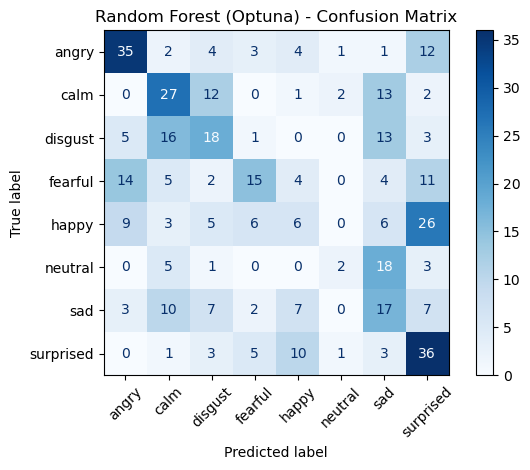

Classification Report (Random Forest - Optuna):
              precision    recall  f1-score   support

       angry       0.53      0.56      0.55        62
        calm       0.39      0.47      0.43        57
     disgust       0.35      0.32      0.33        56
     fearful       0.47      0.27      0.34        55
       happy       0.19      0.10      0.13        61
     neutral       0.33      0.07      0.11        29
         sad       0.23      0.32      0.27        53
   surprised       0.36      0.61      0.45        59

    accuracy                           0.36       432
   macro avg       0.36      0.34      0.33       432
weighted avg       0.36      0.36      0.34       432

Training Accuracy: 0.9821
Testing Accuracy: 0.3611


In [16]:
# Train final model with best parameters from Optuna
best_rf_optuna = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(**study_rf.best_trial.params)
)

best_rf_optuna.fit(X_train, y_train)

# Evaluate on test set
y_pred_rf_optuna = best_rf_optuna.predict(X_test)

# Confusion Matrix
cm_rf_optuna = confusion_matrix(y_test, y_pred_rf_optuna)
disp_rf_optuna = ConfusionMatrixDisplay(confusion_matrix=cm_rf_optuna, 
                                         display_labels=best_rf_optuna.classes_)
disp_rf_optuna.plot(cmap='Blues', xticks_rotation=45)
plt.title('Random Forest (Optuna) - Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report (Random Forest - Optuna):")
print(classification_report(y_test, y_pred_rf_optuna))

# Calculate accuracy
train_score_rf_optuna = best_rf_optuna.score(X_train, y_train)
test_score_rf_optuna = best_rf_optuna.score(X_test, y_test)

print(f"Training Accuracy: {train_score_rf_optuna:.4f}")
print(f"Testing Accuracy: {test_score_rf_optuna:.4f}")

## Gradient Boosting Classifier with Optuna

In [17]:
# Define objective function for Gradient Boosting Classifier
def objective_gbc(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }
    
    # Create pipeline
    gbc_pipeline_optuna = make_pipeline(
        StandardScaler(),
        GradientBoostingClassifier(**params)
    )
    
    # Use cross-validation to evaluate
    scores = cross_val_score(gbc_pipeline_optuna, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()

# Create study and optimize
print("Starting Gradient Boosting Classifier optimization with Optuna...")
study_gbc = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_gbc.optimize(objective_gbc, n_trials=30, show_progress_bar=True)

print(f"\nBest trial:")
print(f"  Value (CV Accuracy): {study_gbc.best_trial.value:.4f}")
print(f"  Params: {study_gbc.best_trial.params}")

Starting Gradient Boosting Classifier optimization with Optuna...


Best trial: 17. Best value: 0.375991: 100%|██████████| 30/30 [13:47<00:00, 27.58s/it]


Best trial:
  Value (CV Accuracy): 0.3760
  Params: {'n_estimators': 167, 'learning_rate': 0.01404223704759201, 'max_depth': 4, 'subsample': 0.843703982484205, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 7}


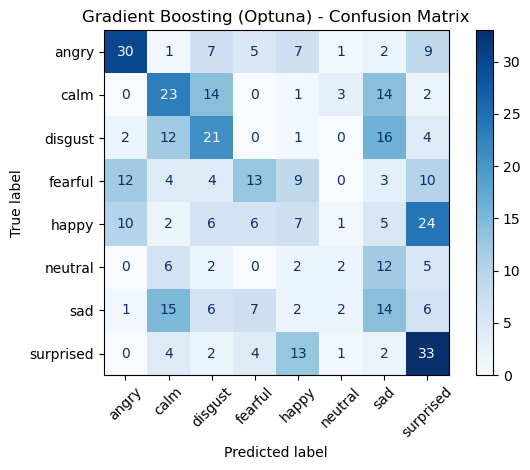

Classification Report (GBC - Optuna):
              precision    recall  f1-score   support

       angry       0.55      0.48      0.51        62
        calm       0.34      0.40      0.37        57
     disgust       0.34      0.38      0.36        56
     fearful       0.37      0.24      0.29        55
       happy       0.17      0.11      0.14        61
     neutral       0.20      0.07      0.10        29
         sad       0.21      0.26      0.23        53
   surprised       0.35      0.56      0.43        59

    accuracy                           0.33       432
   macro avg       0.32      0.31      0.30       432
weighted avg       0.33      0.33      0.32       432

Training Accuracy: 0.9583
Testing Accuracy: 0.3310


In [18]:
# Train final model with best parameters from Optuna
best_gbc_optuna = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(**study_gbc.best_trial.params)
)

best_gbc_optuna.fit(X_train, y_train)

# Evaluate on test set
y_pred_gbc_optuna = best_gbc_optuna.predict(X_test)

# Confusion Matrix
cm_gbc_optuna = confusion_matrix(y_test, y_pred_gbc_optuna)
disp_gbc_optuna = ConfusionMatrixDisplay(confusion_matrix=cm_gbc_optuna, 
                                          display_labels=best_gbc_optuna.classes_)
disp_gbc_optuna.plot(cmap='Blues', xticks_rotation=45)
plt.title('Gradient Boosting (Optuna) - Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report (GBC - Optuna):")
print(classification_report(y_test, y_pred_gbc_optuna))

# Calculate accuracy
train_score_gbc_optuna = best_gbc_optuna.score(X_train, y_train)
test_score_gbc_optuna = best_gbc_optuna.score(X_test, y_test)

print(f"Training Accuracy: {train_score_gbc_optuna:.4f}")
print(f"Testing Accuracy: {test_score_gbc_optuna:.4f}")

## Optuna Optimization Visualization

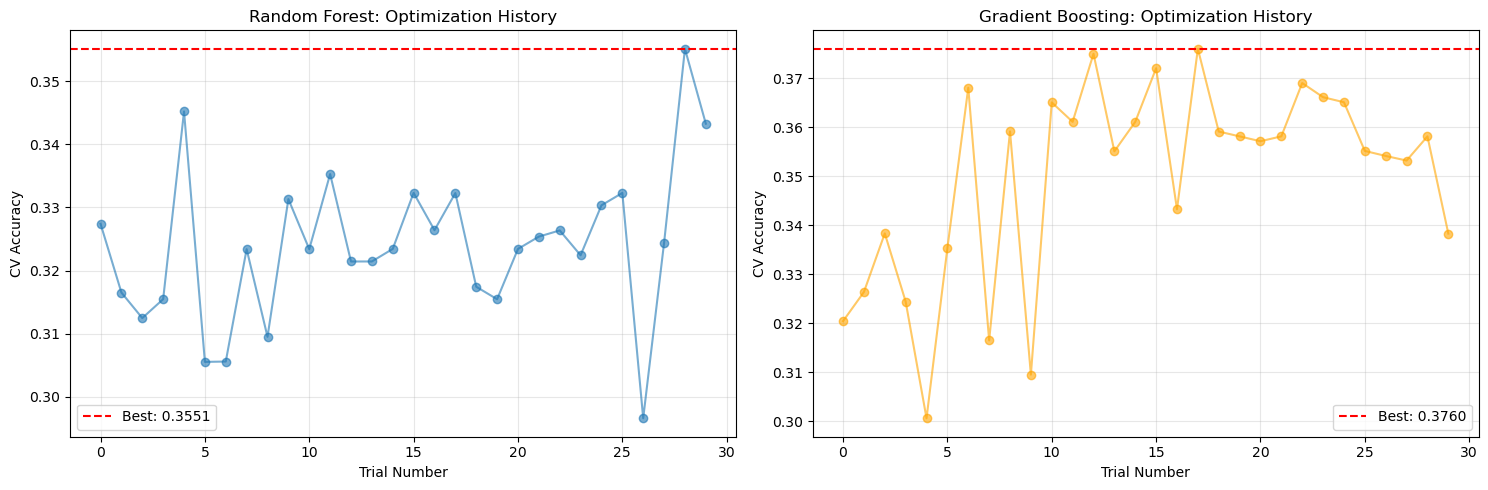

Random Forest - Best trial was # 28
GBC - Best trial was # 17


In [50]:
# Optimization history for Random Forest and GBC
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RF optimization history
rf_trials = [(trial.number, trial.value) for trial in study_rf.trials]
rf_numbers, rf_values = zip(*rf_trials)

axes[0].plot(rf_numbers, rf_values, 'o-', alpha=0.6)
axes[0].axhline(y=study_rf.best_value, color='r', linestyle='--', label=f'Best: {study_rf.best_value:.4f}')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('CV Accuracy')
axes[0].set_title('Random Forest: Optimization History')
axes[0].legend()
axes[0].grid(alpha=0.3)

# GBC optimization history
gbc_trials = [(trial.number, trial.value) for trial in study_gbc.trials]
gbc_numbers, gbc_values = zip(*gbc_trials)

axes[1].plot(gbc_numbers, gbc_values, 'o-', alpha=0.6, color='orange')
axes[1].axhline(y=study_gbc.best_value, color='r', linestyle='--', label=f'Best: {study_gbc.best_value:.4f}')
axes[1].set_xlabel('Trial Number')
axes[1].set_ylabel('CV Accuracy')
axes[1].set_title('Gradient Boosting: Optimization History')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Save plot
import os
os.makedirs('../output/EDA_plots', exist_ok=True)
plt.savefig('../output/EDA_plots/hyperparameter_tuning_optuna_history.png', dpi=300, bbox_inches='tight')

plt.show()

print("Random Forest - Best trial was #", study_rf.best_trial.number)
print("GBC - Best trial was #", study_gbc.best_trial.number)

# Final Comparison: Baseline vs RandomizedSearchCV vs Optuna

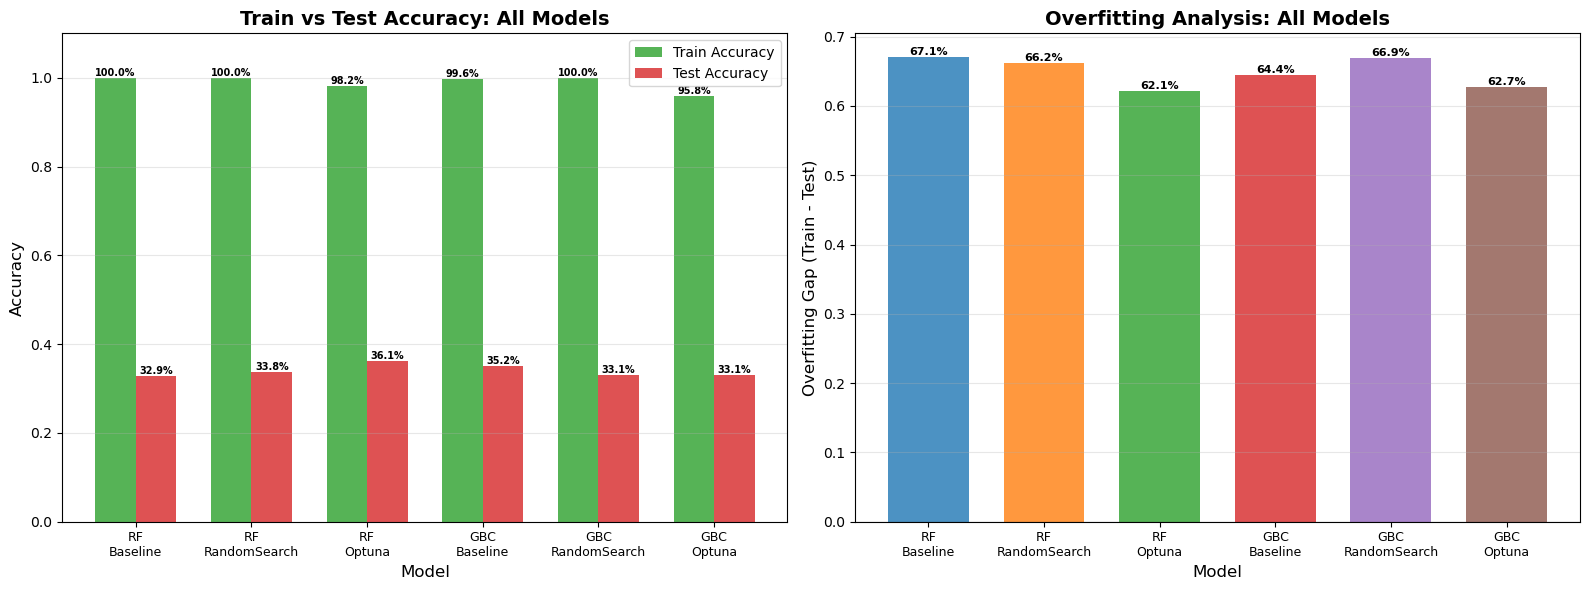

In [47]:
# Create comprehensive comparison dataframe
comparison_data = {
    'Model': [
        'Random Forest (Baseline)',
        'Random Forest (RandomizedSearchCV)',
        'Random Forest (Optuna)',
        'GBC (Baseline)',
        'GBC (RandomizedSearchCV)',
        'GBC (Optuna)'
    ],
    'Train Accuracy': [
        train_score_rf,
        train_score_rf_tuned,
        train_score_rf_optuna,
        train_score_gb,
        train_score_gbc_tuned,
        train_score_gbc_optuna
    ],
    'Test Accuracy': [
        test_score_rf,
        test_score_rf_tuned,
        test_score_rf_optuna,
        test_score_gb,
        test_score_gbc_tuned,
        test_score_gbc_optuna
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Overfitting Gap'] = comparison_df['Train Accuracy'] - comparison_df['Test Accuracy']

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Train vs Test Accuracy
models_short = ['RF\nBaseline', 'RF\nRandomSearch', 'RF\nOptuna', 'GBC\nBaseline', 'GBC\nRandomSearch', 'GBC\nOptuna']
train_scores = comparison_df['Train Accuracy']
test_scores = comparison_df['Test Accuracy']

x = np.arange(len(models_short))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_scores, width, alpha=0.8, label='Train Accuracy', color='#2ca02c')
bars2 = axes[0].bar(x + width/2, test_scores, width, alpha=0.8, label='Test Accuracy', color='#d62728')

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Train vs Test Accuracy: All Models', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_short, fontsize=9)
axes[0].legend(loc='upper right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}',
                ha='center', va='bottom', fontsize=7, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}',
                ha='center', va='bottom', fontsize=7, fontweight='bold')

# Plot 2: Overfitting Analysis
overfitting_gaps = comparison_df['Overfitting Gap']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

bars3 = axes[1].bar(x, overfitting_gaps, width*2, alpha=0.8, color=colors)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Overfitting Gap (Train - Test)', fontsize=12)
axes[1].set_title('Overfitting Analysis: All Models', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models_short, fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, gap in zip(bars3, overfitting_gaps):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{gap:.1%}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# Add horizontal line at y=0
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

plt.tight_layout()

# Save plot
import os
os.makedirs('../output/EDA_plots', exist_ok=True)
plt.savefig('../output/EDA_plots/19_hyperparameter_tuning_final_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

# ROC-AUC Analysis

ROC (Receiver Operating Characteristic) and AUC (Area Under Curve) analysis for multi-class classification.

For 8-class emotion classification, we use the One-vs-Rest approach where:
- Each class is treated as positive once while all other classes are negative
- ROC curve is computed for each class
- Macro-average AUC is calculated across all classes

In [33]:
# Get all unique emotion classes
classes = rf_pipeline.classes_
n_classes = len(classes)

# Binarize the test labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=classes)

print(f"Number of classes: {n_classes}")
print(f"Classes: {classes}")
print(f"Binarized labels shape: {y_test_bin.shape}")

Number of classes: 8
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Binarized labels shape: (432, 8)


In [34]:
# Function to compute ROC curve and AUC for each class
def compute_roc_auc(y_true_bin, y_score, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, roc_auc

print("ROC-AUC computation function defined")

ROC-AUC computation function defined


In [35]:
# Get prediction scores for all 6 models
y_score_rf_baseline = rf_pipeline.predict_proba(X_test)
y_score_rf_tuned = rf_random_search.best_estimator_.predict_proba(X_test)
y_score_rf_optuna = best_rf_optuna.predict_proba(X_test)

y_score_gbc_baseline = gb_pipeline.predict_proba(X_test)
y_score_gbc_tuned = gbc_random_search.best_estimator_.predict_proba(X_test)
y_score_gbc_optuna = best_gbc_optuna.predict_proba(X_test)

print("Prediction scores obtained for all models")

Prediction scores obtained for all models


In [36]:
# Compute ROC curves for all models
fpr_rf_baseline, tpr_rf_baseline, roc_auc_rf_baseline = compute_roc_auc(y_test_bin, y_score_rf_baseline, n_classes)
fpr_rf_tuned, tpr_rf_tuned, roc_auc_rf_tuned = compute_roc_auc(y_test_bin, y_score_rf_tuned, n_classes)
fpr_rf_optuna, tpr_rf_optuna, roc_auc_rf_optuna = compute_roc_auc(y_test_bin, y_score_rf_optuna, n_classes)

fpr_gbc_baseline, tpr_gbc_baseline, roc_auc_gbc_baseline = compute_roc_auc(y_test_bin, y_score_gbc_baseline, n_classes)
fpr_gbc_tuned, tpr_gbc_tuned, roc_auc_gbc_tuned = compute_roc_auc(y_test_bin, y_score_gbc_tuned, n_classes)
fpr_gbc_optuna, tpr_gbc_optuna, roc_auc_gbc_optuna = compute_roc_auc(y_test_bin, y_score_gbc_optuna, n_classes)

print("ROC curves computed for all 6 models")

ROC curves computed for all 6 models


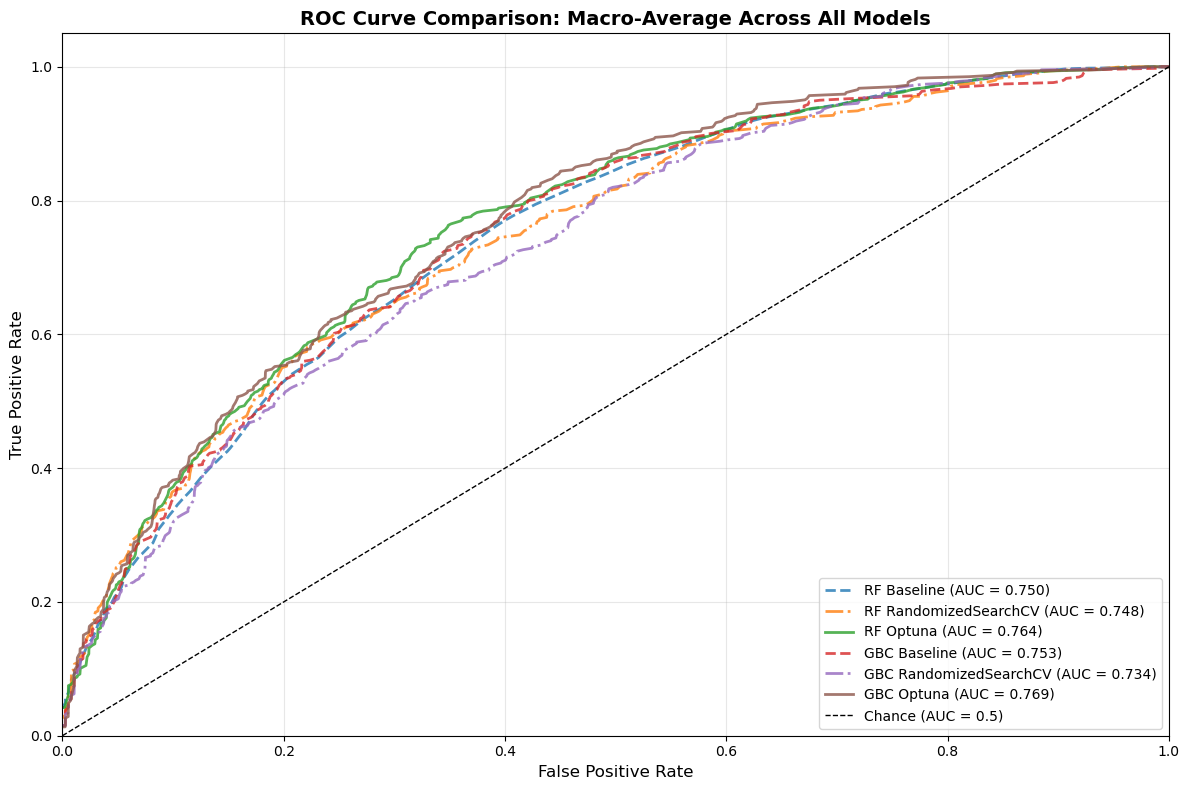

In [49]:
# Create macro-average ROC curve comparison
plt.figure(figsize=(12, 8))

# Plot macro-average ROC curve for all models
plt.plot(fpr_rf_baseline["macro"], tpr_rf_baseline["macro"],
         label=f'RF Baseline (AUC = {roc_auc_rf_baseline["macro"]:.3f})',
         linewidth=2, linestyle='--', alpha=0.8)

plt.plot(fpr_rf_tuned["macro"], tpr_rf_tuned["macro"],
         label=f'RF RandomizedSearchCV (AUC = {roc_auc_rf_tuned["macro"]:.3f})',
         linewidth=2, linestyle='-.', alpha=0.8)

plt.plot(fpr_rf_optuna["macro"], tpr_rf_optuna["macro"],
         label=f'RF Optuna (AUC = {roc_auc_rf_optuna["macro"]:.3f})',
         linewidth=2, alpha=0.8)

plt.plot(fpr_gbc_baseline["macro"], tpr_gbc_baseline["macro"],
         label=f'GBC Baseline (AUC = {roc_auc_gbc_baseline["macro"]:.3f})',
         linewidth=2, linestyle='--', alpha=0.8)

plt.plot(fpr_gbc_tuned["macro"], tpr_gbc_tuned["macro"],
         label=f'GBC RandomizedSearchCV (AUC = {roc_auc_gbc_tuned["macro"]:.3f})',
         linewidth=2, linestyle='-.', alpha=0.8)

plt.plot(fpr_gbc_optuna["macro"], tpr_gbc_optuna["macro"],
         label=f'GBC Optuna (AUC = {roc_auc_gbc_optuna["macro"]:.3f})',
         linewidth=2, alpha=0.8)

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Chance (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: Macro-Average Across All Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)

plt.savefig('../output/EDA_plots/20_hyperparameter_tuning_roc_curves_macro_average_all_models.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [38]:
# Create AUC comparison summary
auc_comparison = pd.DataFrame({
    'Model': [
        'Random Forest (Baseline)',
        'Random Forest (RandomizedSearchCV)',
        'Random Forest (Optuna)',
        'GBC (Baseline)',
        'GBC (RandomizedSearchCV)',
        'GBC (Optuna)'
    ],
    'Macro-Average AUC': [
        roc_auc_rf_baseline["macro"],
        roc_auc_rf_tuned["macro"],
        roc_auc_rf_optuna["macro"],
        roc_auc_gbc_baseline["macro"],
        roc_auc_gbc_tuned["macro"],
        roc_auc_gbc_optuna["macro"]
    ],
    'Micro-Average AUC': [
        roc_auc_rf_baseline["micro"],
        roc_auc_rf_tuned["micro"],
        roc_auc_rf_optuna["micro"],
        roc_auc_gbc_baseline["micro"],
        roc_auc_gbc_tuned["micro"],
        roc_auc_gbc_optuna["micro"]
    ]
})

print("ROC-AUC SUMMARY")
display(auc_comparison)

# Find best model by AUC
best_auc_idx = auc_comparison['Macro-Average AUC'].idxmax()
best_auc_model = auc_comparison.loc[best_auc_idx, 'Model']
best_auc_score = auc_comparison.loc[best_auc_idx, 'Macro-Average AUC']

print(f"\nBEST MODEL BY MACRO-AVERAGE AUC: {best_auc_model}")
print(f"Macro-Average AUC: {best_auc_score:.4f}")

ROC-AUC SUMMARY


,Model,Macro-Average AUC,Micro-Average AUC
0,Random Forest (Baseline),0.750458,0.758385
1,Random Forest (RandomizedSearchCV),0.748033,0.753698
2,Random Forest (Optuna),0.764255,0.768978
3,GBC (Baseline),0.752635,0.761825
4,GBC (RandomizedSearchCV),0.733837,0.741805
5,GBC (Optuna),0.768749,0.772479



BEST MODEL BY MACRO-AVERAGE AUC: GBC (Optuna)
Macro-Average AUC: 0.7687


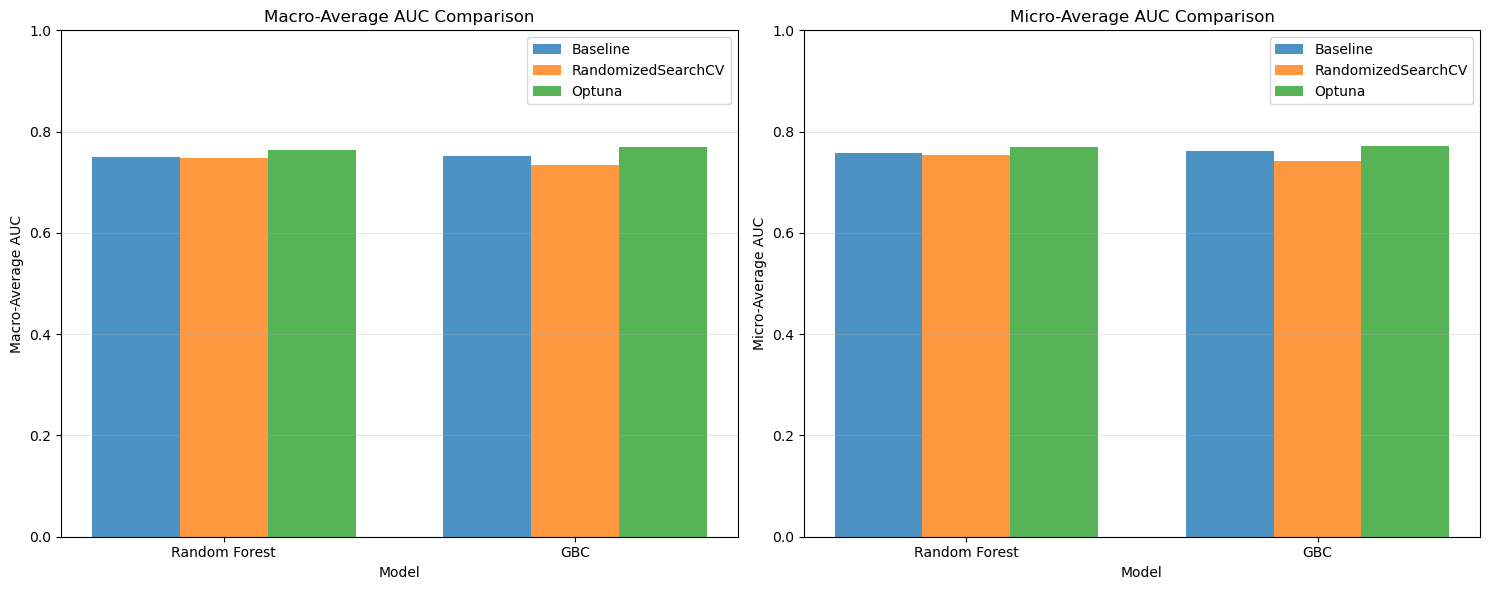

In [39]:
# Visualize AUC comparison across models
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

models = ['Random Forest', 'GBC']
baseline_auc = [roc_auc_rf_baseline["macro"], roc_auc_gbc_baseline["macro"]]
randomsearch_auc = [roc_auc_rf_tuned["macro"], roc_auc_gbc_tuned["macro"]]
optuna_auc = [roc_auc_rf_optuna["macro"], roc_auc_gbc_optuna["macro"]]

x = np.arange(len(models))
width = 0.25

# Plot 1: Macro-Average AUC comparison
axes[0].bar(x - width, baseline_auc, width, label='Baseline', alpha=0.8)
axes[0].bar(x, randomsearch_auc, width, label='RandomizedSearchCV', alpha=0.8)
axes[0].bar(x + width, optuna_auc, width, label='Optuna', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Macro-Average AUC')
axes[0].set_title('Macro-Average AUC Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Plot 2: Micro-Average AUC comparison
baseline_auc_micro = [roc_auc_rf_baseline["micro"], roc_auc_gbc_baseline["micro"]]
randomsearch_auc_micro = [roc_auc_rf_tuned["micro"], roc_auc_gbc_tuned["micro"]]
optuna_auc_micro = [roc_auc_rf_optuna["micro"], roc_auc_gbc_optuna["micro"]]

axes[1].bar(x - width, baseline_auc_micro, width, label='Baseline', alpha=0.8)
axes[1].bar(x, randomsearch_auc_micro, width, label='RandomizedSearchCV', alpha=0.8)
axes[1].bar(x + width, optuna_auc_micro, width, label='Optuna', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Micro-Average AUC')
axes[1].set_title('Micro-Average AUC Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Save Trained Models

Saving all trained models to avoid retraining in future sessions.

In [40]:
import joblib
import os

# Create models directory if it doesn't exist
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

print(f"Models directory: {models_dir}")
print(f"Directory exists: {os.path.exists(models_dir)}")

Models directory: ../models
Directory exists: True


In [41]:
# Save all 6 trained models
models_to_save = {
    'rf_baseline.pkl': rf_pipeline,
    'rf_randomizedsearch.pkl': rf_random_search.best_estimator_,
    'rf_optuna.pkl': best_rf_optuna,
    'gbc_baseline.pkl': gb_pipeline,
    'gbc_randomizedsearch.pkl': gbc_random_search.best_estimator_,
    'gbc_optuna.pkl': best_gbc_optuna
}

print("Saving models...")
for filename, model in models_to_save.items():
    filepath = os.path.join(models_dir, filename)
    joblib.dump(model, filepath)
    file_size = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  Saved {filename} ({file_size:.2f} MB)")

print("\nAll models saved successfully!")

Saving models...
  Saved rf_baseline.pkl (8.17 MB)
  Saved rf_randomizedsearch.pkl (4.18 MB)
  Saved rf_optuna.pkl (5.36 MB)
  Saved gbc_baseline.pkl (3.41 MB)
  Saved gbc_randomizedsearch.pkl (6.36 MB)
  Saved gbc_optuna.pkl (5.52 MB)

All models saved successfully!


In [42]:
# Save the hyperparameter search objects as well (contains search history)
search_objects = {
    'rf_randomizedsearch_full.pkl': rf_random_search,
    'gbc_randomizedsearch_full.pkl': gbc_random_search,
    'rf_optuna_study.pkl': study_rf,
    'gbc_optuna_study.pkl': study_gbc
}

print("Saving hyperparameter search objects...")
for filename, obj in search_objects.items():
    filepath = os.path.join(models_dir, filename)
    joblib.dump(obj, filepath)
    file_size = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  Saved {filename} ({file_size:.2f} MB)")

print("\nAll search objects saved successfully!")

Saving hyperparameter search objects...
  Saved rf_randomizedsearch_full.pkl (5.03 MB)
  Saved gbc_randomizedsearch_full.pkl (7.21 MB)
  Saved rf_optuna_study.pkl (0.01 MB)
  Saved gbc_optuna_study.pkl (0.02 MB)

All search objects saved successfully!
